In [1]:
#July 28
"""
Adding in a star-forming fraction to account for the difference of sf vs quiescent galaxies
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [2]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

### Putting it into ARES

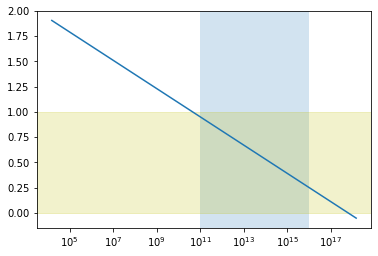

In [19]:
base_pars = ares.util.ParameterBundle('emma:model1')
pop = ares.populations.GalaxyPopulation(**base_pars)

base_pars.update(pop_sf_type='sf')
pop_sf = ares.populations.GalaxyPopulation(**base_pars)

base_pars.update(pop_sf_type='q')
pop_q = ares.populations.GalaxyPopulation(**base_pars)

fract = pop_sf._SF_fraction_PQ()

# print(fract(x=pop_halo.halos.tab_M))

pl.semilogx(pop_halo.halos.tab_M, fract(x=pop_halo.halos.tab_M))
pl.axvspan(10**11, 10**16, alpha=0.2)
pl.axhspan(0, 1, alpha=0.2, color="y")

pl.show()

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\analysis\GalaxyPopulation.py:1259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


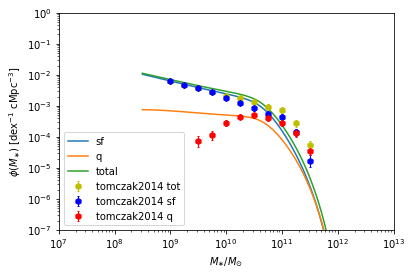

In [18]:
Sm = np.linspace(8.5, 12.1, num=100)
z = 1.75

smf_sf = pop_sf.StellarMassFunction(z, Sm)
pl.loglog(10**Sm, smf_sf, label='sf')

smf_q = pop_q.StellarMassFunction(z, Sm)
pl.loglog(10**Sm, smf_q, label='q')

smf = pop.StellarMassFunction(z, Sm)
pl.loglog(10**Sm, smf, label='total')

data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 tot", quantity="smf_tot")
data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 sf", color="b", ecolor='b',  mec='b')
data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 q", quantity="smf_q")

pl.legend()
pl.show()

#### Quenched vs SF
For given mass, what is chance it is quenched?  
Parametrize # objects that are quenched wrt (mass, z)

This gives two different gals: SF >> Q  
	SF: Dn/dm * sf_fract  
	Q: Dn/dm * (1-sf_fract)   

Sf_fract ~ linear to mass for now (halo mass I guess?)


# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


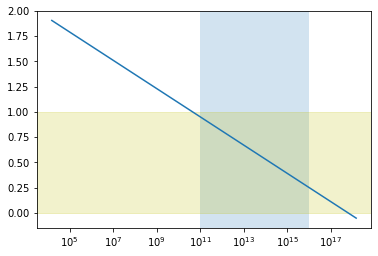

In [5]:
#it's a fraction so [0, 1] - how to make sure this happens? cause mass is going to be a big value
#also which way should it go? --> higher HM =  lower sf fraction

sf_frac = lambda c, b, mass: c*mass + b

def fract(c, b):
    
#     f = -c*np.log10(pop_halo.halos.tab_M) + b
    #should it be logged?
    
    f = fract_points(11, 16.5)
    
    return f

def fract_points(minM, maxM):
    perMin = 0.95
    perMax = 0.25
    
    m = (perMax - perMin) / (maxM - minM)
    f = m*(np.log10(pop_halo.halos.tab_M) - maxM) + perMax
    
    return f

# pl.semilogx(pop_halo.halos.tab_M, fract(0.05, 1))
pl.semilogx(pop_halo.halos.tab_M, fract_points(11, 16))
pl.axvspan(10**11, 10**16, alpha=0.2)
pl.axhspan(0, 1, alpha=0.2, color="y")

pl.show()

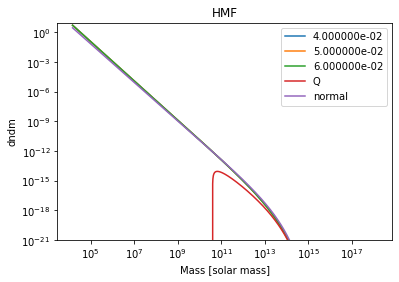

In [6]:
z = 2

# for c in [1e-18, 1e-19, 1e-20]:
for c in [0.04, 0.05, 0.06]:

    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*fract(c, 1), label='%e' %c)

pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*(1-fract(1, 1)), label='Q')

    
pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :], label='normal')
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-21, 10)
pl.show()

In [7]:
# derivative of m(M) wrt M
def dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = mM_ratio - pop_halo.halos.tab_M * 2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx

#derivative of log10( m ) wrt M
def dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    
    dydx = -1* ((gamma-1)*(pop_halo.halos.tab_M/M_1)**(gamma+beta) - beta - 1) / (np.log(10)*pop_halo.halos.tab_M*((pop_halo.halos.tab_M/M_1)**(gamma+beta) + 1))

    return dydx

In [8]:
#double power law
c = 0.05
b = 1

def SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf=True):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    """
    tab_dndm (halo) -> dndlog(m) (SM)
    need: tab_dndm / d(log(ratio)/dM
    """
    
    if sf: #star-forming 
        SMF = pop_halo.halos.tab_dndm[k, :]*fract(c, b) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    else: # quiescent
        SMF = pop_halo.halos.tab_dndm[k, :]*(1-fract(c, b)) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM

    
    return SMF,  mM_ratio

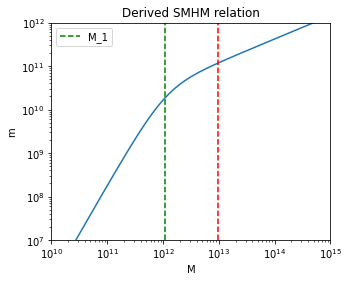

7.695769e+10


In [18]:
z = 1

N = N_0 * (z + 1)**nu
M_1 = 10**(logM_0*(z+1)**mu)
beta = beta_1*z+beta_0
gamma = gamma_0*(z + 1)**gamma_1

SMF, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma) #* pop_halo.halos.tab_M
ratio = 10**(r)
HM = pop_halo.halos.tab_M

fig, ax = pl.subplots(1, 1, figsize=(5, 4))
pl.subplots_adjust(hspace=0)

ax.set_title("Derived SMHM relation")
ax.loglog(HM, ratio*pop_halo.halos.tab_M)#, label='c = %.e' %c)

ax.set(xlabel='M', ylabel='m')
ax.set_ylim(1e7, 1e12)
ax.set_xlim(1e10, 1e15)
ax.axvline(M_1, color="g", label="M_1", ls="--")

ax.legend()

from scipy.interpolate import interp1d

f = interp1d(ratio*pop_halo.halos.tab_M, HM)

# ax.axvline(f(10**8), color="r", label="M", ls="--")
ax.axvline(10**pop.HM_fromSM(z, 11), color="r", label="M", ls="--")

pl.show()

print("{:e}".format(f(10**8)))

### Higher redshift
With redshift-dependent parameterizations

$logM_1 = logM_0 \cdot (z + 1)^\mu$  
$N_1 = N_0 \cdot (z + 1)^\nu$  
$\gamma = \gamma_0 \cdot (z + 1)^{\gamma_1}$  
$\beta = \beta_1 \cdot z + \beta_0 $ 

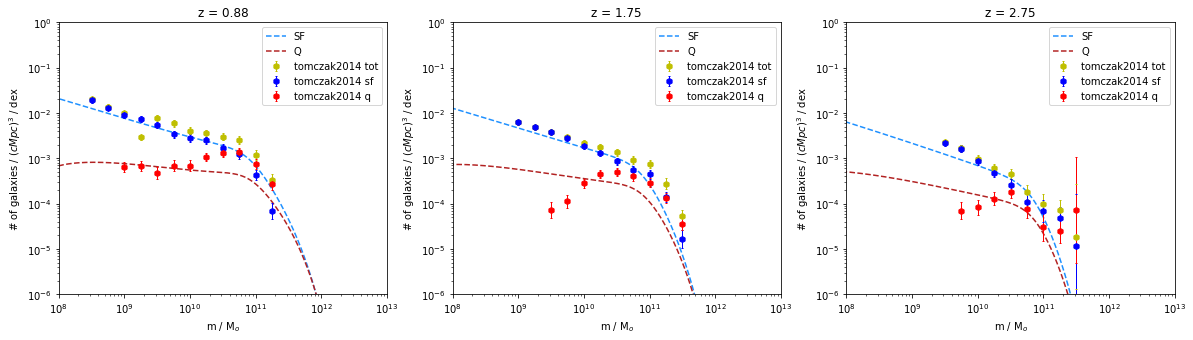

In [19]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

# [(0.35) sf only, 0.875, 1.125, 1.75, 2.25, 2.75]

for i, z in enumerate([0.875, 1.75, 2.75]):
    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0*(z+1)**mu)
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
       
    #plot lit values
    data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 tot", quantity="smf_tot", ax=axs[i])
    data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 sf", ax=axs[i], color="b", ecolor='b',  mec='b')
    data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 q", quantity="smf_q", ax=axs[i])
    
    SMF_sf, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma)
    SMF_q, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf=False)

    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))

    #plotting
    axs[i].loglog(Sm, SMF_sf, label='SF', ls="--", color='dodgerblue')
    axs[i].loglog(Sm, SMF_q, label='Q', ls="--", color='firebrick')
    
    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
    axs[i].set_xlim(1e8, )

    axs[i].legend()

pl.show()

In [25]:
def fract_points_z(z, minSM, maxSM):
    perMin = 0.95
    perMax = 0.25
    
    minHM = pop.HM_fromSM(z, minSM)
    maxHM = pop.HM_fromSM(z, maxSM)
    
    m = (perMax - perMin) / (maxHM - minHM)
    f = m*(np.log10(pop_halo.halos.tab_M) - maxHM) + perMax
    
    return f

In [26]:
# c = 0.05
# b = 1

minM = 8
maxM = 12.5

def SMF_z(z, pop_halo, N, M_1, beta, gamma, sf=True):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    if sf: #star-forming 
        SMF = pop_halo.halos.tab_dndm[k, :]*fract_points_z(z, minM, maxM) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    else: # quiescent
        SMF = pop_halo.halos.tab_dndm[k, :]*(1-fract_points_z(z, minM, maxM)) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM

    return SMF,  mM_ratio

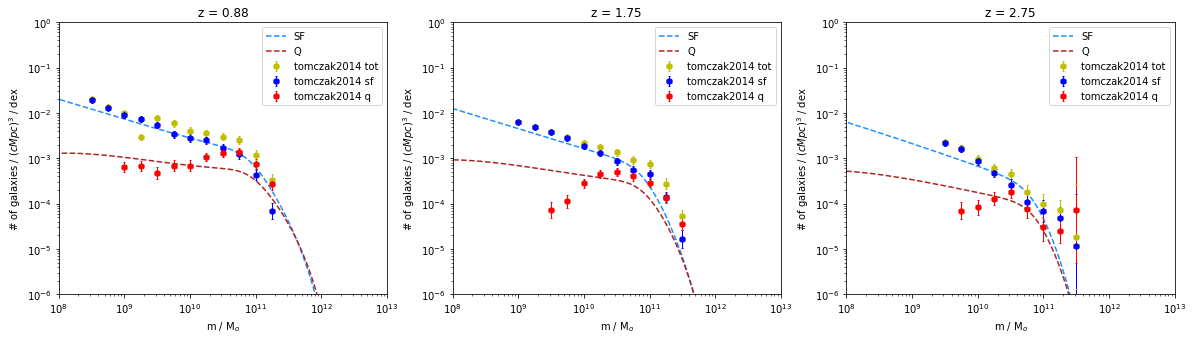

In [27]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

# [(0.35) sf only, 0.875, 1.125, 1.75, 2.25, 2.75]

for i, z in enumerate([0.875, 1.75, 2.75]):
    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0*(z+1)**mu)
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
       
    #plot lit values
    data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 tot", quantity="smf_tot", ax=axs[i])
    data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 sf", ax=axs[i], color="b", ecolor='b',  mec='b')
    data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 q", quantity="smf_q", ax=axs[i])
    
    SMF_sf, r = SMF_z(z, pop_halo, N, M_1, beta, gamma)
    SMF_q, r = SMF_z(z, pop_halo, N, M_1, beta, gamma, sf=False)

    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))

    #plotting
    axs[i].loglog(Sm, SMF_sf, label='SF', ls="--", color='dodgerblue')
    axs[i].loglog(Sm, SMF_q, label='Q', ls="--", color='firebrick')
    
    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
    axs[i].set_xlim(1e8, )

    axs[i].legend()

pl.show()